In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import random
#from time import time
#from tqdm import tqdm
#import tensorflow as tf
#from tfdiffeq import odeint
#from tensorflow.python.framework.ops import convert_to_tensor

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
#beta = tf.constant(10/60)
lb = 1.e-8
ub = 1e1
R = -1.0 / 8.314e-3  # universal gas constant, kJ/mol*K
n_exp = 3
n_train = 3
n_para = 3
batchsize = 16
atol = 1e-6
rtol = 1e-3
grad_max = 1.e2
exp_species = 3
n_species = 4
start = True
init_lr = 0.001
max_epoch = 500
p_cutoff = 0.0

In [ ]:
exp_data = pd.read_excel('/content/drive/MyDrive/TGA_Data_Cel_CelK_5mg_10HR_for_NN.xlsx' , sheet_name = 5)

In [ ]:
exp_data

,Time (s),Temp (K),Residual (-),Time (s).1,Temp (K).1,Residual (-).1,Time (s).2,Temp (K).2,Residual (-).2
0,0,490.70,1.000000,0,500.03,1.000000,0,491.30,1.000000
1,1,490.93,1.000000,1,500.26,1.000000,1,491.51,1.000000
2,2,491.14,1.000000,2,500.46,1.000000,2,491.73,1.000000
3,3,491.36,1.000000,3,500.69,1.000000,3,491.92,1.000000
4,4,491.56,1.000000,4,500.92,1.000000,4,492.15,1.000000
...,...,...,...,...,...,...,...,...,...
2282,2282,873.28,0.080709,2282,879.93,0.068273,2282,873.56,0.064909
2283,2283,873.41,0.080709,2283,879.95,0.068273,2283,873.73,0.064909
2284,2284,873.59,0.080709,2284,880.03,0.068273,2284,873.90,0.064909
2285,2285,873.76,0.080709,2285,880.07,0.068273,2285,874.07,0.064909


In [ ]:
exp_data = exp_data.iloc[:5000]
exp_data

,Time (s),Temp (K),Residual (-),Time (s).1,Temp (K).1,Residual (-).1,Time (s).2,Temp (K).2,Residual (-).2
0,0.0,523.22,1.000000,0.0,518.72,1.000000,0,516.54,1.000000
1,1.0,523.41,0.999970,1.0,518.92,0.999993,1,516.73,0.999964
2,2.0,523.60,0.999940,2.0,519.10,0.999986,2,516.94,0.999932
3,3.0,523.79,0.999909,3.0,519.30,0.999977,3,517.10,0.999902
4,4.0,523.99,0.999879,4.0,519.50,0.999968,4,517.31,0.999875
...,...,...,...,...,...,...,...,...,...
2154,NaN,NaN,NaN,NaN,NaN,NaN,2154,873.22,0.003496
2155,NaN,NaN,NaN,NaN,NaN,NaN,2155,873.38,0.003518
2156,NaN,NaN,NaN,NaN,NaN,NaN,2156,873.55,0.003546
2157,NaN,NaN,NaN,NaN,NaN,NaN,2157,873.71,0.003581


In [ ]:
#exp_data1 = exp_data[exp_data['Temp (K)'] < 500].iloc[::100].reset_index(drop=True)
exp_data1 = exp_data[(exp_data['Temp (K)'] <= 650)].iloc[::20]
exp_data2 = exp_data[(exp_data['Temp (K)'] > 650)].iloc[::50]
exp_data = pd.concat([exp_data1, exp_data2]).reset_index(drop = True)
exp_data1.shape, exp_data2.shape

((38, 9), (28, 9))

In [ ]:
from google.colab import files

exp_data.to_excel('exp_data_5mg_5HR_1%K.xlsx', encoding = 'utf-8-sig', header = False, index = False)
files.download('exp_data_5mg_5HR_1%K.xlsx')

/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
T0_exp = np.zeros(n_exp)

indx = exp_data.shape[0]
exp_data_mass = np.zeros((indx, n_para , n_exp))
for i in range(n_exp):
  exp_data_mass[:,:,i] = exp_data.iloc[:,n_para*i : n_para * (i + 1)]
  #exp_data_mass[:,:,i] = np.round(exp_data_mass[:,:,i], 2)
  T0_exp[i] = exp_data_mass[:,:,i][0,1]

In [ ]:
T0_exp

array([523.22, 518.72, 516.54])

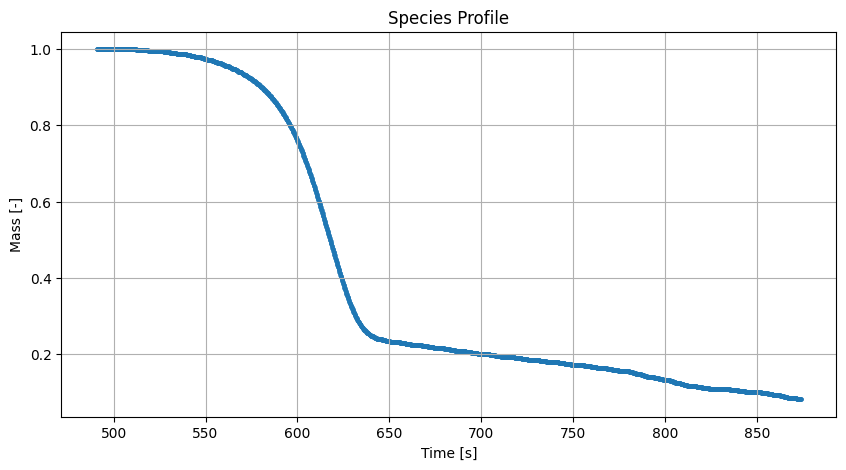

In [ ]:
i_exp = 0
plt.figure(figsize=(10,5))
plt.scatter(exp_data_mass[:,1,i_exp], exp_data_mass[:,2,i_exp] , s = 5)
#plt.scatter(exp_data_mass[:,0,i_exp], exp_data_mass[:,2,2] , s = 1)
#plt.scatter(exp_data_mass[:,0,i_exp], exp_data_mass[:,2,1] , s = 1)
#plt.scatter(lit_data_exp2[:,1], lit_data_exp2[:,2] , s = 5)
#plt.scatter(lit_data_exp9[:,1], lit_data_exp9[:,2] , s = 5)
#plt.legend(["EXP", "Lit_exp2", "Lit_exp9"])
plt.xlabel('Time [s]')
plt.ylabel('Mass [-]')
#plt.ylim(0,1.1)
plt.title('Species Profile')
plt.grid()
plt.show()

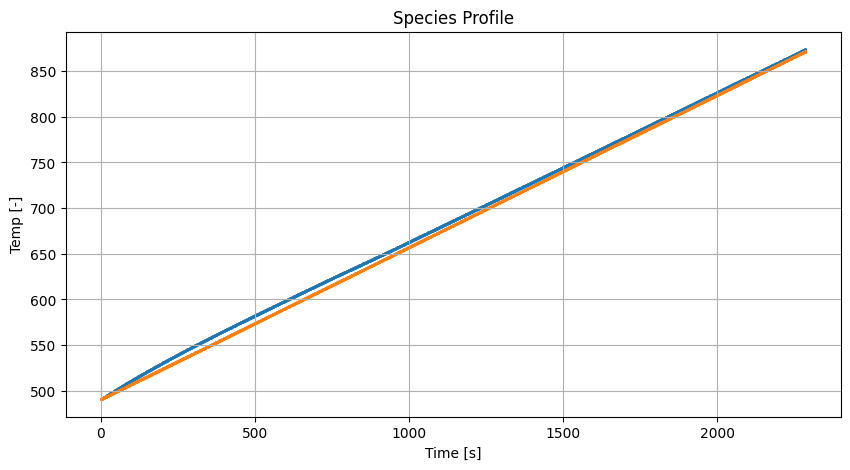

In [ ]:
i_exp = 0
Temp = T0_exp[i_exp] + (10/60)*exp_data['Time (s)'].values
plt.figure(figsize=(10,5))
plt.scatter(exp_data_mass[:,0,i_exp], exp_data_mass[:,1,i_exp] , s = 1)
plt.scatter(exp_data_mass[:,0,i_exp], Temp , s = 1)
plt.xlabel('Time [s]')
plt.ylabel('Temp [-]')
plt.title('Species Profile')
plt.grid()
plt.show()

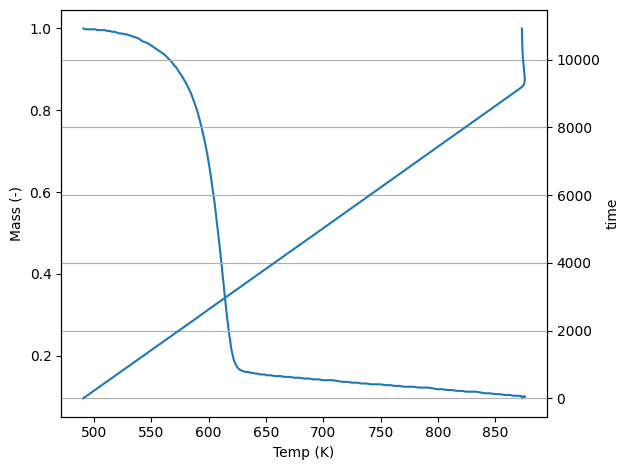

In [ ]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Temp (K)')
ax1.set_ylabel('Mass (-)')
ax1.plot(exp_data_mass[:,1,i_exp] , exp_data_mass[:,2,i_exp])
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

ax2.set_ylabel('time')
ax2.plot(exp_data_mass[:,1,i_exp], exp_data_mass[:,0,i_exp])
ax2.tick_params(axis='y')

fig.tight_layout()
plt.grid()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
(300)/(1750/60)

10.285714285714285

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(lit_data_exp2[:,0], lit_data_exp2[:,2], s = 5)
plt.scatter(lit_data_exp2[:,0], 1 - lit_data_exp2[:,2] , s = 5)
plt.legend(["Residual", "Volatile"])
plt.xlabel('Time [s]')
plt.ylabel('Mass [-]')
plt.title('Species Profile')
plt.grid()

plt.show()

NameError: name 'lit_data_exp2' is not defined

<Figure size 1500x500 with 0 Axes>